# Project Notebook for Team 4
Team members: Brian Morris and Akram Mahmoud

In [2]:
import ast
import matplotlib.pyplot as plt
import music21
import numpy as np
import os

import pandas as pd
import kerastuner as kt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

/var/folders/x5/cgpxmq_11ys090v206spbw7w0000gn/T/ipykernel_50536/479987768.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


#### Getting Started

1. download the dataset from [kaggle](https://www.kaggle.com/datasets/blanderbuss/midi-classic-music/code)

2. Move the dataset to where the notebook will be run, unarchive, and rename the parent folder to data

4. in your terminal run `pip install keras-tuner`

5. in your terminal `pip install music21`

## CNN Model

### 1. Data Preprocessing and 2. Feature Extraction
The dataset was provided as a collection of midi files. After investigating various libraries, we decided to use music21 to parse the midi files and extract the notes and chords. music 21 is "a python toolkit designed for computational analysis, and capable of handling a range of filetypes including MIDI" (Simonetta et al., 2023)
Load the data from the dataset, use music21 to parse the midi files and extract the notes and chords.

In my first iteration of extraction, I created separate arrays for notes, chords, and tempo. However, extracting data in this pattern seemed suboptimal, as it missed the relationship between the notes and chords in time, and tempo wasn't related to the notes.

I searched for a better approach and found a paper by Verma and Thickstun (2019) that used a similar dataset to do composer prediction. Specifically, they paid more attention to the temporal aspect of the music.
After reading their paper, I took a deeper dive of music21 documentation, to understand available features. I decided to re-extract the data, this time creating Tuples consisting of the note pitch, what beat the note occured on, and the note duration (e.g quarter note, half note, whole note).
According to the Music21 documentation the note's pitch is "a number between 0 and 127 where middle C (C4) is 60 and C#4/Db4 is 61, B3 is 59, etc." (Music21, n.d.). I captured rests as -1 to better profile the music. For chords, I added up the individual pitches of the composing notes. 

Each Tuple is either a:
- Note: (note pitch, beat, duration)
- Chord: (sum of individual note pitches, beat, duration)
- Rest: (pitch of -1, beat, duration)

In this way I can capture the temporal relationship between the notes and chords, and include rests in the data, which seems like an important feature to include in the model. The output then looks like:
> (-1, 1.0, 0.5), (48, 1.0, 1.0), (72, 1.5, .25)...

##### Helper Functions

In [ ]:
def extract_note_features(midi_file):
    """
    Extracts note features from a MIDI file, including pitch, beat, 
    and duration, returning a list of tuples for each note, rest, 
    or chord in the file.
    """
    midi = music21.converter.parse(midi_file)
    
    note_tuples = []
    for thisNote in midi.flatten().getElementsByClass(['Note', 'Rest', 'Chord']):
        if thisNote.isNote:
            pitch = thisNote.pitch.midi
        elif thisNote.isRest:
            # Use -1 for rest
            pitch = -1
        elif thisNote.isChord:
            combined_pitch = 0
            for pitch in thisNote.pitches:
                combined_pitch += pitch.midi
            pitch = combined_pitch
        note_tuples.append((pitch, round(float(thisNote.beat), 2), round(float(thisNote.duration.quarterLength), 2)))
    
    return note_tuples

In [4]:
def extract_first_last_tuples(sequences, total_len):
    """
    Extracts the first and last segments of a sequence, combines them, and pads 
    or truncates the result to a specified total length.
    """
    seq_len = len(sequences)
    half_len = total_len // 2
    if seq_len >= total_len:
        # If the sequence is longer than or equal to total_len, take the first and last 
        first_half = sequences[:half_len]
        last_half = sequences[-half_len:]
        combined = first_half + last_half
    else:
        combined = sequences

    combined = pad_sequences([combined], maxlen=total_len, padding='post', truncating='post', dtype='float32')[0]
    
    return combined

In [5]:
composer_list = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
data = []

In [ ]:
# Not executed the notebook submitted for the report, as it takes a long time to run
for composer in composer_list:
    for dirname, _, filenames in os.walk(f'./data/{composer}/'):
        for filename in filenames:
            if filename.endswith('.mid'):
                midi_path = os.path.join(dirname, filename)
                note_tuples = extract_note_features(midi_path)
                data.append({
                    'midi_file': filename,
                    'composer': composer,
                    'path': dirname,
                    'note_tuple': note_tuples,
                })

In [ ]:
df = pd.DataFrame(data)

In [7]:
df.head()

,midi_file,composer,path,note_tuple
0,Bwv0997 Partita for Lute 1mov.mid,Bach,./data/Bach/,"[(-1, 4.0, 2.0), (48, 4.0, 4.0), (72, 6.0, 1.0..."
1,Bwv0535 Prelude and Fugue.mid,Bach,./data/Bach/,"[(-1, 4.0, 16.0), (55, 4.0, 1.0), (-1, 4.0, 16..."
2,Bwv0806 English Suite n1 05mov.mid,Bach,./data/Bach/,"[(69, 4.0, 2.0), (-1, 4.0, 2.0), (69, 5.0, 9.3..."
3,Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid,Bach,./data/Bach/,"[(-1, 4.0, 1.0), (39, 4.0, 4.0), (-1, 4.0, 6.0..."
4,Jesu Joy of Man Desiring.mid,Bach,./data/Bach/,"[(-1, 4.0, 1.33), (-1, 4.0, 1.33), (-1, 4.0, 4..."


In [8]:
print(df.shape)
print(df.isna().sum())

(1530, 4)
midi_file     0
composer      0
path          0
note_tuple    0
dtype: int64


In [9]:
df['composer'].value_counts()

composer
Bach         925
Mozart       257
Beethoven    212
Chopin       136
Name: count, dtype: int64

<Axes: xlabel='composer'>

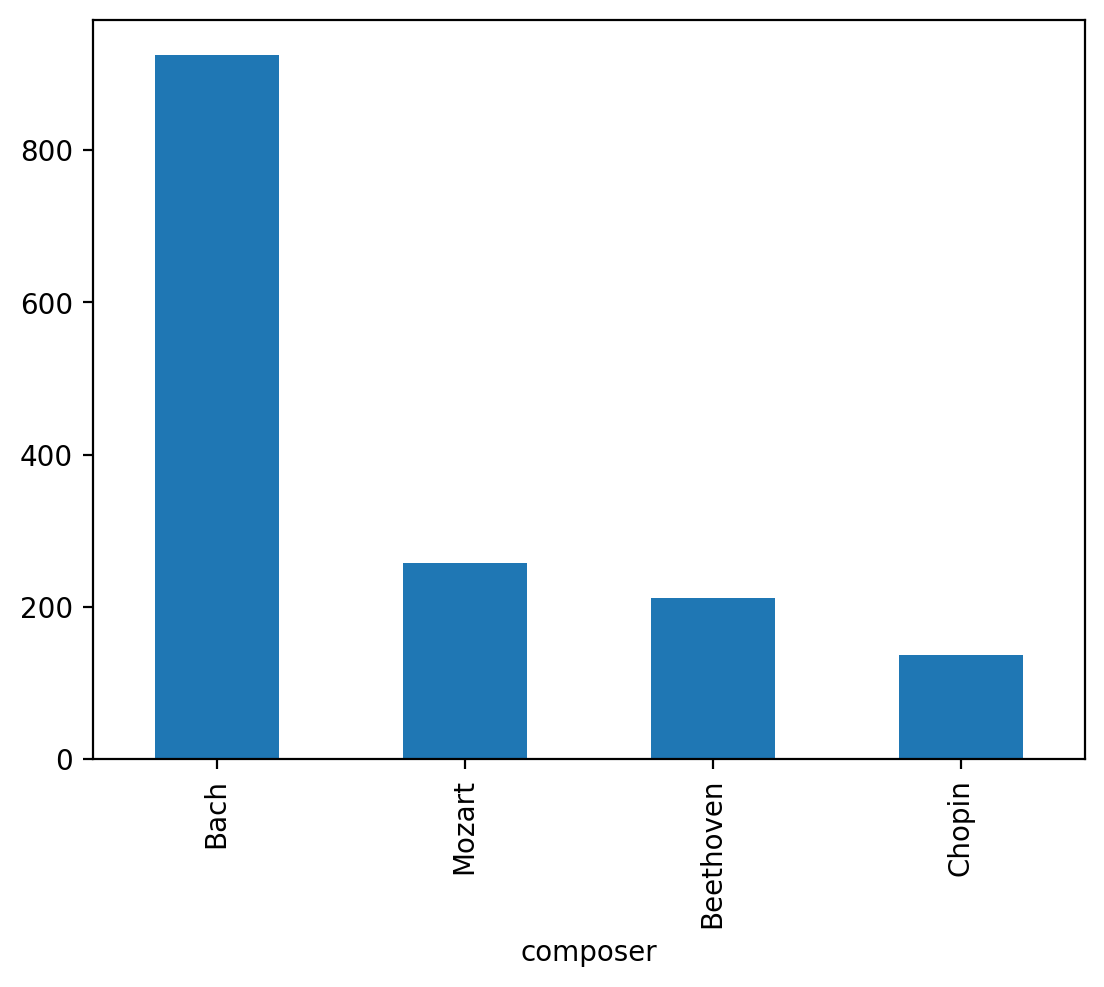

In [10]:
# Visualize the distribution of composers
df['composer'].value_counts().plot(kind='bar')

In [ ]:
# Save the extracted features for Model training
df.to_csv('./data/preprocessed_tuple_with_midi.csv', index=False)

In [6]:
# Combining my prepocessing and model training notebooks into a single notebook for submission
df = pd.read_csv('./data/preprocessed_tuple_with_midi.csv')

In [11]:
# Need to convert the note_tuple column from string to list of tuples
df['note_tuple'] = df['note_tuple'].apply(lambda x: ast.literal_eval(x))

In [12]:
TOTAL_NOTE_COUNT = 500
# Extract the first and last segments of the note tuples
df['first_last_tuples'] = df['note_tuple'].apply(lambda x: extract_first_last_tuples(x, TOTAL_NOTE_COUNT))

#### 3. Model Building 
I ran several dozen experiments trying to identify the best model composition, hyperparameters, and features. I initially extracted the note pitch, the root chord, and the tempo. I ran a few experiments determining the impact of adding tempo, chords, and SMOTE to the training. 
Additionally, I started with the first 1000 notes, and played around with increasing the number of notes to 5000 and 10,000 under the assumption that more notes would provide more context to the model.

However, this was not the case, and the model consistently achieved a high training accuracy above 98%, but performed poorly on the validation set. I did see some small improvements with SMOTE and inclusion of tempo and chords in the training data, but the model was still overfitting, even with aggressive dropout rates. Other adjustments to reduce overfitting, such as reducing the batch size and layers were also unsuccessful. Model accuracy in the test set before I started hyperparameter tuning was in the 50%, and only improved to the 60-70% range with hours of hyperparameter tuning.

This lead me to conduct more research on the problem. I found a paper by Verma and Thickstun (2019) that discussed the challenges of overfitting when training models on entire musical scores, particularly due to the high dimensionality of the data. To mitigate this, they propose sub-sampling techniques, such as using the first and last few hundred notes from each score. This approach balances the need to capture essential features while avoiding overfitting to specific patterns that may not generalize well across different compositions. The authors found that this method improves model performance by focusing on the most informative sections of the score without overwhelming the model with redundant data (Verma & Thickstun, 2019).

The data is highly imbalanced, with Bach comprising of a majority of the datase (925). I used SMOTE to balance the data, but only saw a small improvement in the model's performance.

This approach is what is currently shown here in the code, with hyperparameter tuning applied to this approach.

##### Helper Functions

In [13]:

def apply_smote(X, y):
    """
    Applies SMOTE to balance the classes in the dataset.
    """
    smote = SMOTE(random_state=42)  

    num_samples, num_timesteps, num_features = X.shape
    X_flatten = X.reshape(num_samples, -1)

    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_flatten, y)

    X_smote_reshaped = X_smote.reshape(X_smote.shape[0], num_timesteps, num_features)

    return X_smote_reshaped, y_smote

In [14]:

class CNNHyperModel(kt.HyperModel):
    """
    CNN model for hyperparameter tuning using Keras Tuner.
    The keras Tuner doesn't support epochs or batch_size as a parameter, so I overloaded the fit method to include them.
    """
    def build(self, hp):
        model = Sequential()
        model.add(Conv1D(filters=hp.Int('filters_1', min_value=64, max_value=192, step=64),
                        kernel_size=3,
                        activation='relu',
                        kernel_regularizer=l2(hp.Choice('l2', [0.001, 0.0001])),
                        input_shape=input_shape))
        model.add(MaxPooling1D(2))
        model.add(Dropout(hp.Choice('dropout_1', [0.2, 0.3, 0.4])))
        
        model.add(Conv1D(filters=hp.Int('filters_2', min_value=64, max_value=192, step=64),
                            kernel_size=3,
                            activation='relu',
                            kernel_regularizer=l2(hp.Choice('l2', [0.001, 0.0001]))))
        model.add(MaxPooling1D(2))
        model.add(Dropout(hp.Choice('dropout_2', [0.2, 0.3, 0.4])))

        if hp.Boolean('add_third_conv_layer'):
            model.add(Conv1D(filters=hp.Int('filters_3', min_value=64, max_value=192, step=64),
                            kernel_size=3,
                            activation='relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(hp.Choice('dropout_3', [0.2, 0.3, 0.4])))
        
        model.add(Flatten())
        model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                        activation='relu',
                        kernel_regularizer=l2(hp.Choice('l2', [0.001, 0.0001]))))
        model.add(Dropout(hp.Choice('dropout_4', [0.2, 0.3, 0.4])))
        
        model.add(Dense(num_classes, activation='softmax'))
        
        learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [24, 32, 40, 48]),
            epochs=hp.Choice("epochs", [15, 20, 30, 50, 100]),
            **kwargs,
        )

In [15]:
X = np.array(df['first_last_tuples'].tolist())

In [16]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(df['composer'])
num_classes = len(label_encoder.classes_)

In [17]:
X_train, X_temp, y_train, y_temp  = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape before Smote", X_train.shape, y_train.shape)
X_train, y_train = apply_smote(X_train, y_train)
print("Shape after Smote", X_train.shape, y_train.shape)

y_train = to_categorical(y_train, num_classes=num_classes)
# Need to apply smote to training before we convert to categorical
y_temp = to_categorical(y_temp, num_classes=num_classes)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Shape before Smote (1224, 500, 3) (1224,)
Shape after Smote (3012, 500, 3) (3012,)


### 4. Model Training
I chose to use the Keras Tuner library for hyperparameter optimiztion. Specifically the BayesianOptimization tuner, as my initial tuning results were giving me a lot of noise, and I wanted to add a high degree of flexibility in the hyperparameter search space. I'm less familiar with tuning hyperparameters for a CNN based model, so decided to search over a lot of my hypothesis, such as learning rate, batch size, a third convolutional layer, and more. BayesianOptimization seems to perform well over large search spaces.

I tried tuning with early stopping but got worse results, so left it out.

Despite many hours of tuning, I had intermittent results with the validation set. Occassionally I had validation set accuracies break into the 70's, but this did not consistenly deliver in the test set. Convergence was also poor, with training and validation accuracies diverging. I suspect that the model is overfitting to the training data despite many interventions to correct that, and that the model is not generalizing well to the test set.

In [19]:
input_shape = X_train.shape[1:]

tuner = kt.BayesianOptimization(
    CNNHyperModel(),
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=2,
    directory='training_dir',
    project_name='cnn_tuning'
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val)
)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 15 Complete [00h 02m 45s]
val_accuracy: 0.6895425021648407

Best val_accuracy So Far: 0.6895425021648407
Total elapsed time: 00h 26m 11s


In [20]:
best_batch_size = best_hps.get('batch_size')
best_epoch = best_hps.get('epochs')
print(f"""
The hyperparameter search is complete. 
Best parameters:
Filters: {best_hps.get('filters_1')} and {best_hps.get('filters_2')}
Dense Units: {best_hps.get('dense_units')}
Dropout: {best_hps.get('dropout_1')}, {best_hps.get('dropout_2')}, {best_hps.get('dropout_3')}, {best_hps.get('dropout_4')}
Regularization: {best_hps.get('l2')}
2nd convo layer: {best_hps.get('add_third_conv_layer')}
Learning Rate: {best_hps.get('learning_rate')}
Batch Size: {best_batch_size}
Epoch: {best_epoch}
""")


The hyperparameter search is complete. 
Best parameters:
Filters: 64 and 64
Dense Units: 64
Dropout: 0.2, 0.4, 0.2, 0.2
Regularization: 0.0001
2nd convo layer: False
Learning Rate: 0.001
Batch Size: 48
Epoch: 100



In [21]:
# Train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_epoch, batch_size=best_batch_size)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2656 - loss: 9.9131 - val_accuracy: 0.2288 - val_loss: 1.4025
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2437 - loss: 1.4040 - val_accuracy: 0.3922 - val_loss: 1.3430
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3128 - loss: 1.3657 - val_accuracy: 0.4575 - val_loss: 1.1502
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3377 - loss: 1.3014 - val_accuracy: 0.5294 - val_loss: 1.0534
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3495 - loss: 1.2998 - val_accuracy: 0.5425 - val_loss: 1.0383
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3890 - loss: 1.2438 - val_accuracy: 0.5098 - val_loss: 1.0436
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4108 - loss: 1.2104 - val_accuracy: 0.4706 - val_loss: 1.0397
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4820 - loss: 1.1482 - val_accuracy: 0.

### 5. Model Evaluation

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6662 - loss: 2.9096
Test accuracy: 0.6666666865348816


In [25]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

        Bach       0.77      0.91      0.84        87
   Beethoven       0.54      0.28      0.37        25
      Chopin       0.75      0.30      0.43        10
      Mozart       0.38      0.42      0.40        31

    accuracy                           0.67       153
   macro avg       0.61      0.48      0.51       153
weighted avg       0.65      0.67      0.64       153



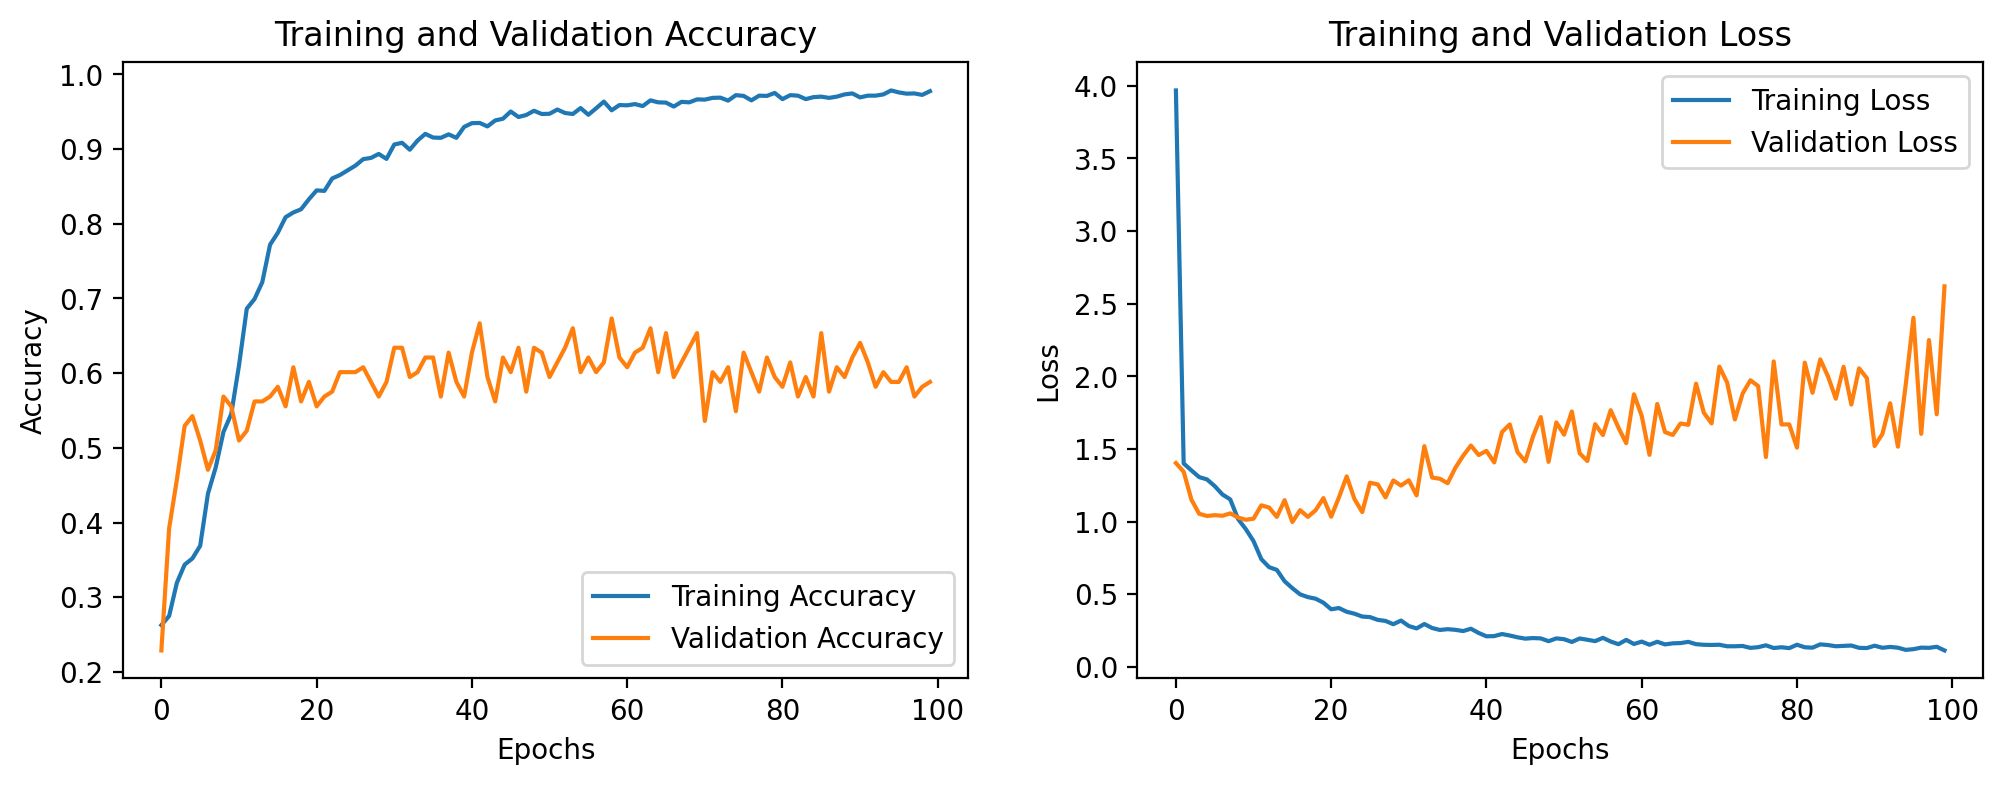

In [24]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 6. Additional Model analysis and Next Steps
As you can see, even with a high degree of hyperparameter tuning and feature extraction, the model is still overfitting, but the validation accuracy is much higher than before. We perform quite high on Bach, but even applying SMOTE to increase the data for the less prevalent composers doesn't offer much improvements. A clear next step would be to gather additional training works for those composers. I believe this is due to the sub-sampling technique I used to extract the data. 

In their study, Verma and Thickstun (2019) discuss the development of a hybrid model for composer identification that combines two CNN models (temporal and harmonic) to enhance predictive accuracy while avoiding overfitting. These models are applied separately to the input data, and their features are then combined in a final layer to make predictions. Given additional time, I would like to explore similar approaches to improve the accuracy of a CNN based approach.

That said, even in their study, Verma and Thickstun were only able to achieve a peak accuracy of 81.7% and that was on a different dataset with 2500 scores, albeit higher number of composers (2019). I think the complexity of music data and the high dimensionality of the data makes it difficult to achieve high accuracy with a CNN model.

### **References:**

- Music21. (n.d.). *Users’ guide: Chapter 3 pitches*. Retrieved August 11, 2024, from https://www.music21.org/music21docs/usersGuide/usersGuide_03_pitches.html

- Verma, H., & Thickstun, J. (2019). Convolutional composer classification. *arXiv preprint arXiv:1911.11737*.

- Simonetta, F., Llorens, A., Serrano, M., García-Portugués, E., & Torrente, Á. (2023). Optimizing feature extraction for symbolic music. *arXiv.* https://doi.org/10.48550/arXiv.2307.05107

#### **Libraries Used:**
- imbalanced-learn - SMOTE:
Lemaitre, G., Nogueira, F., & Aridas, C. K. (2017). Imbalanced-learn: A Python toolbox to tackle the curse of imbalanced datasets in machine learning. *Journal of Machine Learning Research,* 18(17), 1-5. http://jmlr.org/papers/v18/16-365.html

- keras-tuner:
O'Malley, T., Bursztein, E., Long, J., Chollet, F., Jin, H., Invernizzi, L., & others. (2019). *Keras Tuner.* GitHub. https://github.com/keras-team/keras-tuner

- music21:
Cuthbert, M. S. A. (2006-2023). *music21: A toolkit for computer-aided musicology.* GitHub. https://github.com/cuthbertLab/music21
